In [1]:
%load_ext autoreload
%autoreload all

import torch

from gem import MiniFranceDataset
from torch.utils.data import DataLoader, random_split

n_tiles = 4 
dir_path = '/GEM/data/MiniFrance/'
dataset = MiniFranceDataset(dir_path, n_tiles=n_tiles, dataset_type='labeled_train')

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_set, batch_size=2, shuffle=True, num_workers=1)
test_loader = DataLoader(test_set, batch_size=2, shuffle=True, num_workers=1)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


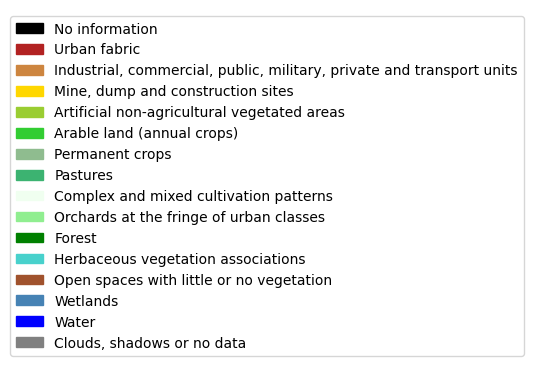

In [2]:
from typing import Any
import matplotlib.colors as mcolors

class_attributes: list[tuple[str, Any]] = [
    ("No information", mcolors.CSS4_COLORS['black']),
    ("Urban fabric", mcolors.CSS4_COLORS['firebrick']),
    ('Industrial, commercial, public, military, private and transport units', mcolors.CSS4_COLORS['peru']),
    ("Mine, dump and construction sites", mcolors.CSS4_COLORS['gold']),
    ("Artificial non-agricultural vegetated areas", mcolors.CSS4_COLORS['yellowgreen']),
    ("Arable land (annual crops)", mcolors.CSS4_COLORS['limegreen']),
    ("Permanent crops", mcolors.CSS4_COLORS['darkseagreen']),
    ("Pastures", mcolors.CSS4_COLORS['mediumseagreen']),
    ("Complex and mixed cultivation patterns", mcolors.CSS4_COLORS['honeydew']),
    ("Orchards at the fringe of urban classes", mcolors.CSS4_COLORS['lightgreen']),
    ("Forest", mcolors.CSS4_COLORS['green']),
    ("Herbaceous vegetation associations", mcolors.CSS4_COLORS['mediumturquoise']),
    ("Open spaces with little or no vegetation", mcolors.CSS4_COLORS['sienna']),
    ('Wetlands', mcolors.CSS4_COLORS['steelblue']),
    ("Water", mcolors.CSS4_COLORS['blue']),
    ("Clouds, shadows or no data", mcolors.CSS4_COLORS['gray']),
]

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

handles = [Patch(color=c, label=l) for l, c in class_attributes]
plt.legend(handles=handles)
plt.gca().set_axis_off()
plt.show()

In [3]:
from gem.model import SegNet
from torch.nn.functional import one_hot
from torchvision.transforms import transforms
from tqdm import tqdm

tile_size = dataset.get_tile_size()
model = SegNet(features=64, out_channels=len(class_attributes))
model.to(device)

def train_one_epoch(optimizer, loss_fn):
    running_loss = 0.
    last_loss = 0.

    for i, data in enumerate(tqdm(train_loader)):
        images = [image for image in data['image']]
        landcover_maps = [image for image in data['landcover_map']]

        input_normalize = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        inputs = torch.stack(images).float().to(device)
        inputs = input_normalize(inputs)

        labels = torch.stack(landcover_maps).to(device)
        labels = one_hot(labels.long(), num_classes=len(class_attributes))
        labels = labels.squeeze(1).permute(0, 3, 1, 2).float()

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = loss_fn(outputs, labels)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

        print_step = 100
        if i % print_step == print_step - 1:
            last_loss = running_loss / print_step # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0.0

    return last_loss

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

model.train(True)
train_one_epoch(optimizer, loss_fn)

  0%|          | 14/4902 [00:09<52:24,  1.55it/s] 


KeyboardInterrupt: 

In [ ]:
torch.save(model, '/GEM/models/model.pth')

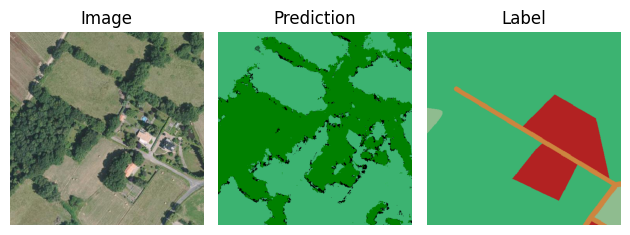

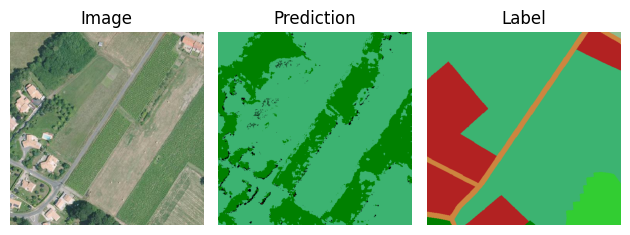

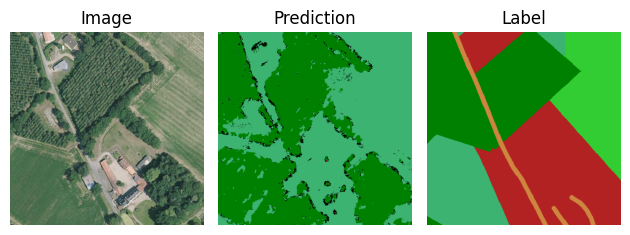

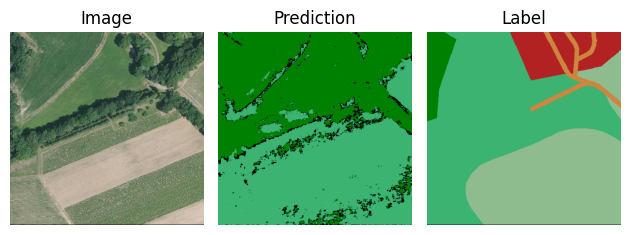

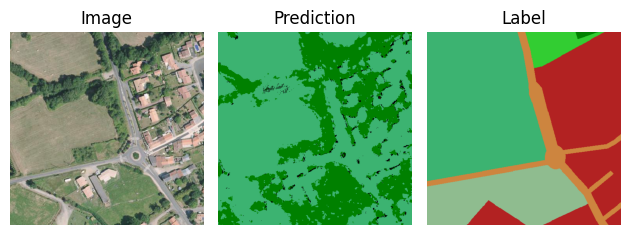

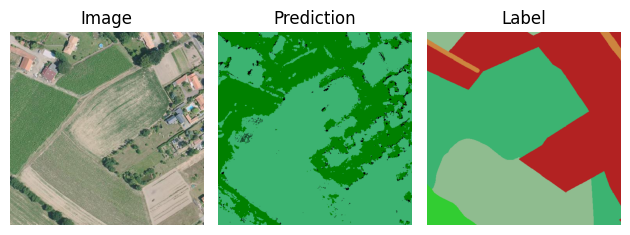

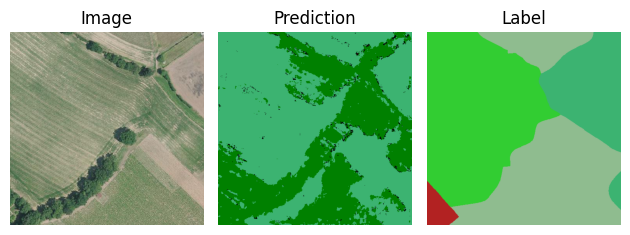

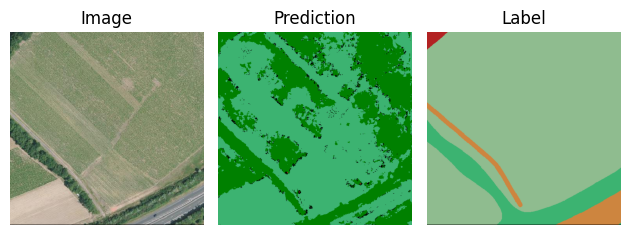

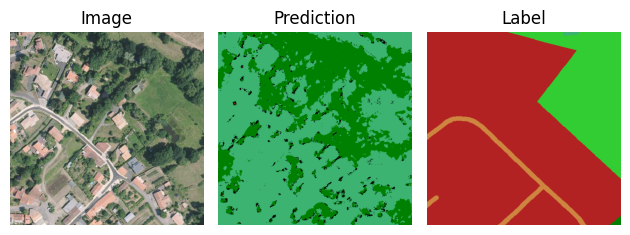

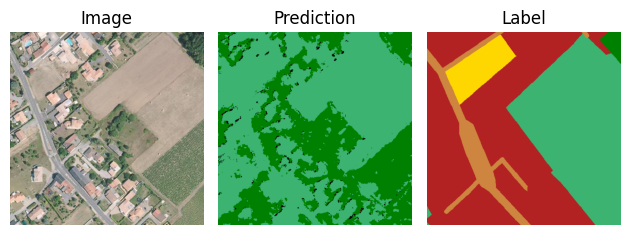

In [5]:
from gem.model import SegNet
import numpy as np
import matplotlib.pyplot as plt

trained_model: SegNet = torch.load('/GEM/models/model.pth')

class_color_lut = np.array([mcolors.hex2color(color) for _, color in class_attributes]) * 255

for i in range(20, 30):
    data = dataset[i]
    image = data['image'].float().to(device).unsqueeze(0) 
    label = data['landcover_map']
    pred = trained_model(image)

    # Plot the image
    plt.subplot(1, 3, 1)
    plt.imshow(image.squeeze().cpu().int().numpy().transpose(1, 2, 0))
    plt.title('Image')
    plt.axis('off')

    # Plot the prediction
    plt.subplot(1, 3, 2)
    pred_img = pred.squeeze().argmax(dim=0).cpu().numpy()
    pred_img = class_color_lut[pred_img]
    plt.imshow(pred_img.astype(np.uint8))
    plt.title('Prediction')
    plt.axis('off')

    # Plot the label
    plt.subplot(1, 3, 3)
    label_img = label.squeeze().cpu().numpy()
    label_img = class_color_lut[label_img]
    plt.imshow(label_img.astype(np.uint8))
    plt.title('Label')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
